In [45]:
! pip install catboost
! pip install --upgrade scikit-learn imbalanced-learn

  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)


## read raw data
there is no need of preprocessing the categorical columns, a catboost model will be used and it handles categories without transformations

In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/business-case-ecommerce/data_raw_1.csv
/kaggle/input/business-case-ecommerce/data_raw_2.csv
/kaggle/input/calibrated_model/other/default/1/calibrated_model.pkl


In [ ]:
df = pd.concat([pd.read_csv(f'../data/raw/data_raw_{str(i)}.csv') for i in [1,2]], axis=0)

df.loc[df['city'].isnull(),'city'] = 'N/A' # 418
df.loc[df['product_name'].isnull(),'product_name'] = 'N/A' # 2
df.loc[df['product_brand'].isnull(),'product_brand'] = 'N/A' # 34
df.loc[df['days_between_orders'].isnull(),'days_between_orders'] = -1 # 40197 if null means that this is the first purchase
df.isnull().sum().sum()

0

In [48]:
from sklearn.model_selection import train_test_split

cat_columns = [ 'gender', 'state', 'city', 'country','traffic_source','product_category', 'product_name', 'product_brand',
               'product_department', 'dc_name']
num_columns = ['age','num_of_item','item_sale_price', 'product_retail_price','events_7_days_add', 'events_7_days_organic',
               'events_7_days_social_network', 'events_7_days_all','events_14_days_add', 'events_14_days_organic',
               'events_14_days_social_network', 'events_14_days_all','events_30_days_add', 'days_between_orders',
               'cancelled_orders','returned_orders', 'num_past_purchase','order_hour', 'order_day','order_month']
target = ['repurchase']

X = df[num_columns+cat_columns]
y = df[target].squeeze()
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('model_train shape: ',X_train.shape,str(sum(y_train)))
print('model_test shape: ',X_test.shape,str(sum(y_test)))

model_train shape:  (36150, 30) 819
model_test shape:  (9038, 30) 205


## catboost model

In [49]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
import numpy as np

classes = np.array([0,1])

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{0: 0.5115903880444935, 1: 22.06959706959707}


In [6]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,# 0.01
    l2_leaf_reg = 5,
    depth=7,
    ############################
    #bagging_temperature = 5,
    class_weights = class_weights,
    min_data_in_leaf=10,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    cat_features=cat_columns
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=30
)

from sklearn.metrics import roc_auc_score
score_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
score_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print('train auc: ', score_train)
print('test auc: ',score_test)
print('diff: ',score_train-score_test)

0:	test: 0.6305451	best: 0.6305451 (0)	total: 172ms	remaining: 2m 52s
100:	test: 0.8406580	best: 0.8406580 (100)	total: 7.42s	remaining: 1m 6s
200:	test: 0.8514429	best: 0.8514429 (200)	total: 14.1s	remaining: 55.9s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8517598915
bestIteration = 202

Shrink model to first 203 iterations.
train auc:  0.9149557149896795
test auc:  0.8517598915375546
diff:  0.06319582345212493


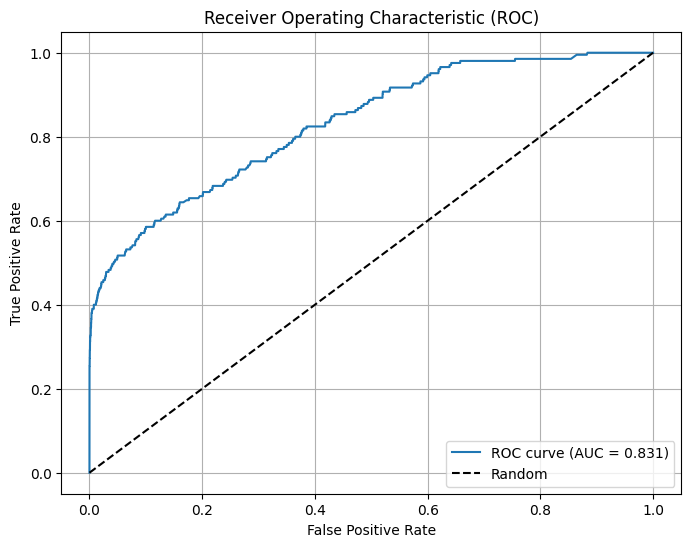

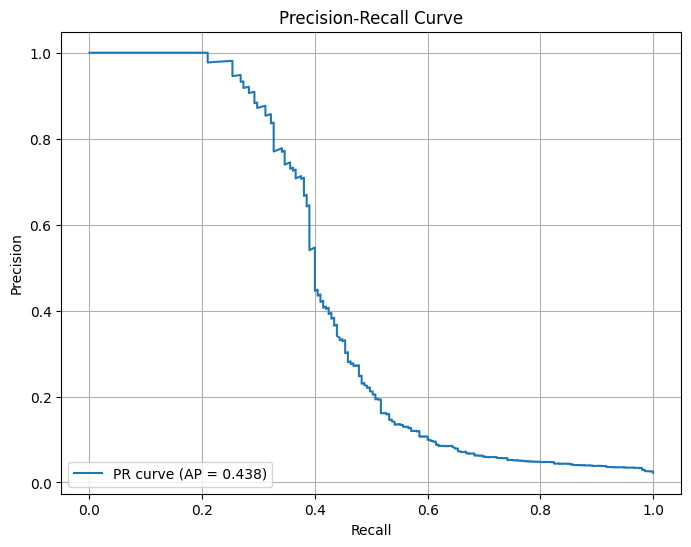

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
y_pred_proba = model.predict_proba(X_test)[:,1]
# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 2. Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


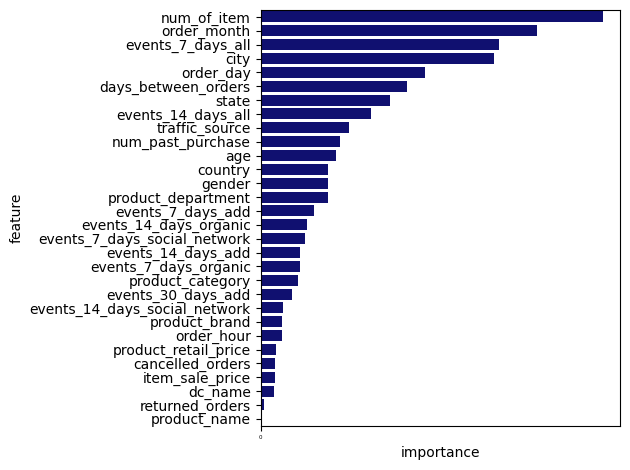

In [16]:
import numpy as np
from catboost import Pool
import seaborn as sns
import matplotlib.pyplot as plt
shap_values = model.get_feature_importance(type='ShapValues', data=Pool(X_test, y_test, cat_features=cat_columns))
# Drop last column (expected value)
shap_vals_only = np.abs(shap_values[:, :-1]).mean(axis=0)

# Rank features based on mean absolute SHAP value
feat_imp_df = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': shap_vals_only
}).sort_values(by='importance', ascending=False)
sns.barplot()
sns.barplot(data = feat_imp_df, y='feature' , x = 'importance', orient='h', color='navy')
plt.xticks(fontsize=4) 
plt.tight_layout()

## calibrate model to use probabilities
As we're using probabilities we'll need to calibrate the model output

In [ ]:
# using calibration for probabilities

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

# 1. Create your uncalibrated CatBoost model (DON'T FIT YET)
base_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,# 0.01
    l2_leaf_reg = 5,
    depth=7,
    class_weights = class_weights,
    min_data_in_leaf=10,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    cat_features=cat_columns
)

# 2. Wrap it with calibration
calibrated_model = CalibratedClassifierCV(
    estimator=base_model,
    method='isotonic',  # or 'isotonic' if you have >10k+ samples
    cv=5  # 5-fold internal cross-validation
)

# 3. Fit on full (X_model, y_model)
calibrated_model.fit(X_train, y_train)

# 4. Predict calibrated probabilities
probs = calibrated_model.predict_proba(X_train)[:, 1]

# Example: interpret a score
print(f"This user has a {probs[0]:.1%} probability of repurchasing.")

score_train = roc_auc_score(y_train, calibrated_model.predict_proba(X_train)[:,1])
score_test = roc_auc_score(y_test, calibrated_model.predict_proba(X_test)[:,1])
print('train auc: ', score_train)
print('test auc: ',score_test)
print('diff: ',score_train-score_test)

0:	total: 117ms	remaining: 1m 56s
100:	total: 5.6s	remaining: 49.8s
200:	total: 11.3s	remaining: 44.9s
300:	total: 16.8s	remaining: 39s
400:	total: 22.3s	remaining: 33.2s
500:	total: 28.4s	remaining: 28.3s
600:	total: 34s	remaining: 22.6s
700:	total: 39.2s	remaining: 16.7s
800:	total: 44.5s	remaining: 11.1s
900:	total: 50.1s	remaining: 5.5s
999:	total: 55.8s	remaining: 0us
0:	total: 96.6ms	remaining: 1m 36s
100:	total: 5.99s	remaining: 53.3s
200:	total: 11.5s	remaining: 45.7s
300:	total: 17s	remaining: 39.4s
400:	total: 22.3s	remaining: 33.3s
500:	total: 27.5s	remaining: 27.4s
600:	total: 33.3s	remaining: 22.1s
700:	total: 38.8s	remaining: 16.6s
800:	total: 44.3s	remaining: 11s
900:	total: 49.7s	remaining: 5.47s
999:	total: 55.2s	remaining: 0us
0:	total: 71.2ms	remaining: 1m 11s
100:	total: 5.13s	remaining: 45.7s
200:	total: 11.2s	remaining: 44.6s
300:	total: 16.8s	remaining: 39s
400:	total: 21.9s	remaining: 32.6s
500:	total: 27s	remaining: 26.9s
600:	total: 32.1s	remaining: 21.3s
700:

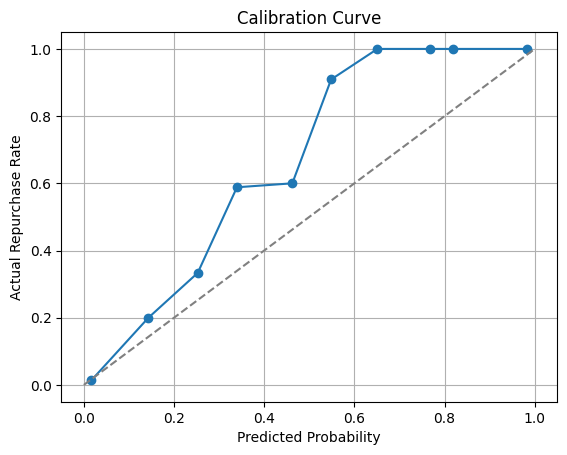

In [18]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, calibrated_model.predict_proba(X_test)[:,1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # perfect calibration
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Repurchase Rate')
plt.title('Calibration Curve')
plt.grid(True)
plt.show()

In [ ]:
# export model in pkl
import pickle
with open('/kaggle/working/catboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('/kaggle/working/calibrated_model.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)


## select treshold based on F1 score

In [52]:
df['year'] = df['order_date'].str.split('-', expand=True)[0]
X_test_2025 = df.loc[df['year']=='2025',num_columns+cat_columns]
y_test_2025 = df.loc[df['year']=='2025',target]

y_pred_proba = calibrated_model.predict_proba(X_test_2025)[:,1]


In [53]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test_2025, y_pred_proba)

# F1 score per threshold
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)

# Best threshold by F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print(f"Best threshold: {best_threshold:.3f}, F1: {f1_scores[best_idx]:.3f}")

Best threshold: 0.082, F1: 0.594


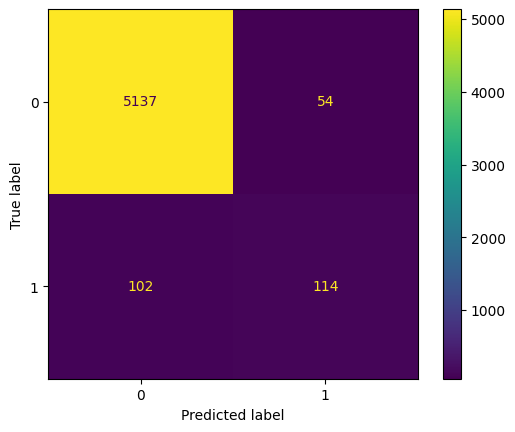

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5191
           1       0.68      0.53      0.59       216

    accuracy                           0.97      5407
   macro avg       0.83      0.76      0.79      5407
weighted avg       0.97      0.97      0.97      5407



In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_pred = y_pred_proba>0.082
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test_2025, y_pred), display_labels = calibrated_model.classes_)
disp.plot()
plt.show()
print(classification_report(y_test_2025, y_pred))

## analysis on data from 2025 (test)

In [54]:
df_2025 = df.loc[df['year']=='2025']
df_2025['pred_modelo'] = y_pred_proba

df_positive = df_2025.loc[df_2025['pred_modelo']>0.082]

/tmp/ipykernel_36/117284487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025['pred_modelo'] = y_pred_proba


In [66]:
df_positive[['age', 'gender', 'state', 'city', 'country','traffic_source', 'pred_modelo']]. groupby(['age', 'gender', 'state', 'city', 'country','traffic_source']).agg('mean').reset_index().to_csv('alta_prob_recompra.csv')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


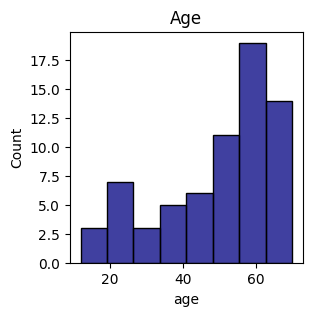

In [79]:
import seaborn as sns
df_unique = df_positive[['age', 'gender', 'state', 'city', 'country','traffic_source']].drop_duplicates()
plt.figure(figsize=(3,3))
sns.histplot(df_unique, x='age', color='navy')
plt.title('Age')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


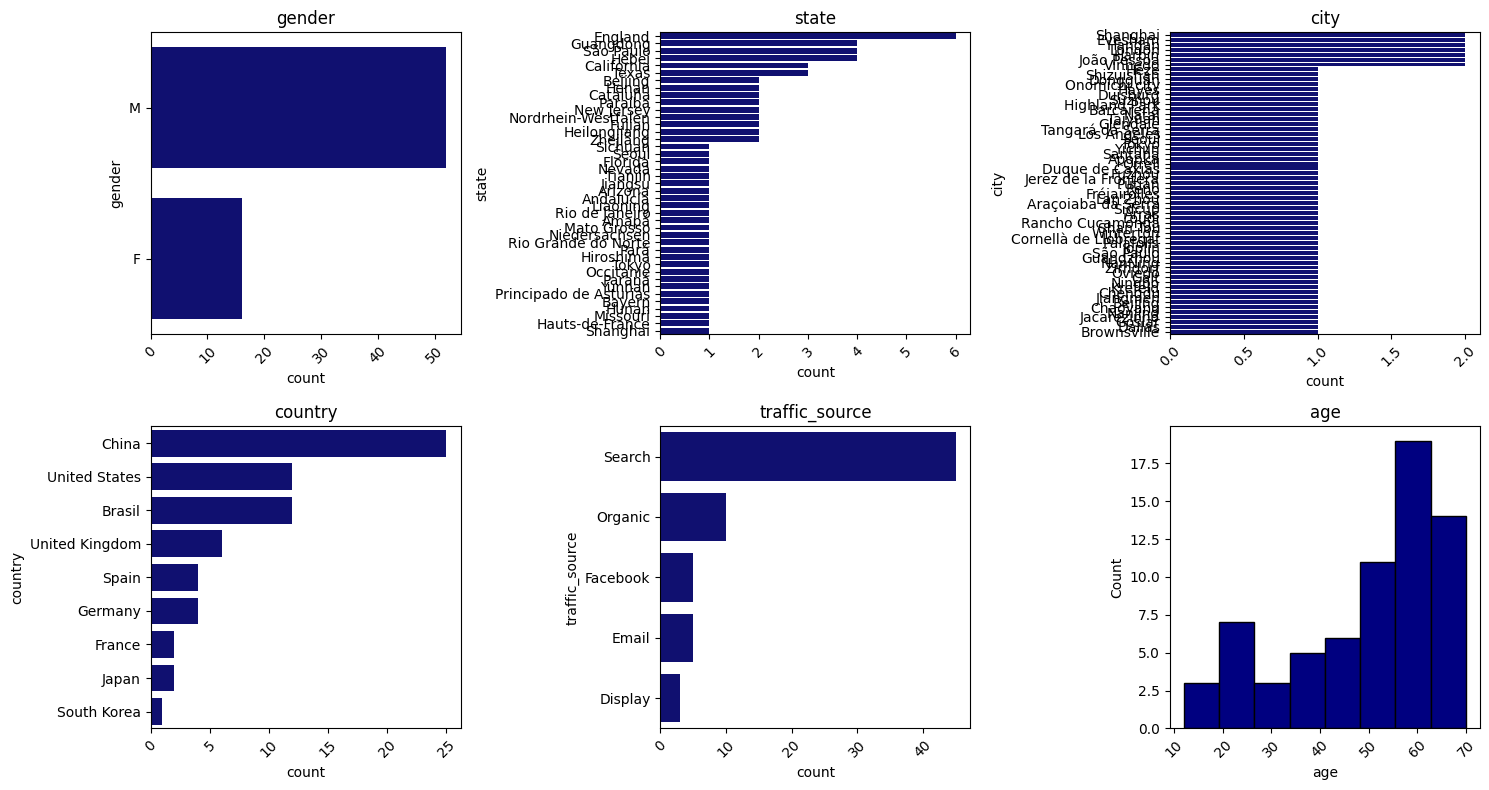

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))  # Adjust size as needed

x = [i for i in range(2) for _ in range(3)]  # row indices: [0, 0, 0, 1, 1, 1]
y = [i for i in range(3)] * 2               # col indices: [0, 1, 2, 0, 1, 2]

cols = ['gender', 'state', 'city', 'country', 'traffic_source']
axes = axes.flatten()  # Flatten to use a single index

for i in range(len(cols)):
    temp = df_unique[cols[i]].value_counts().reset_index()
    temp.columns = [cols[i], 'count']
    
    sns.barplot(
        y=cols[i], 
        x='count', 
        data=temp, 
        ax=axes[i], 
        color='navy', orient='h'
    )
    axes[i].set_title(cols[i])
    axes[i].tick_params(axis='x', rotation=45)

sns.histplot(df_unique, x='age', color='navy',alpha=1)
axes[5].set_title('age')
axes[5].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [103]:
df_unique['days_between_orders'].value_counts()

days_between_orders
-1.0      63
 1.0       5
 2.0       4
 5.0       3
 14.0      2
 6.0       1
 22.0      1
 11.0      1
 212.0     1
 38.0      1
 8.0       1
 812.0     1
 143.0     1
 21.0      1
 13.0      1
 12.0      1
Name: count, dtype: int64

In [94]:
brand_counts = df_positive['product_brand'].value_counts()

# Identify rare brands
rare_brands = brand_counts[brand_counts < 2].index

# Replace them with 'others'
df_positive['product_brand_grouped'] = df_positive['product_brand'].replace(rare_brands, 'others')

temp = df_positive['product_brand_grouped'].value_counts().reset_index()

/tmp/ipykernel_36/106720402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['product_brand_grouped'] = df_positive['product_brand'].replace(rare_brands, 'others')


<Axes: xlabel='count', ylabel='product_brand_grouped'>

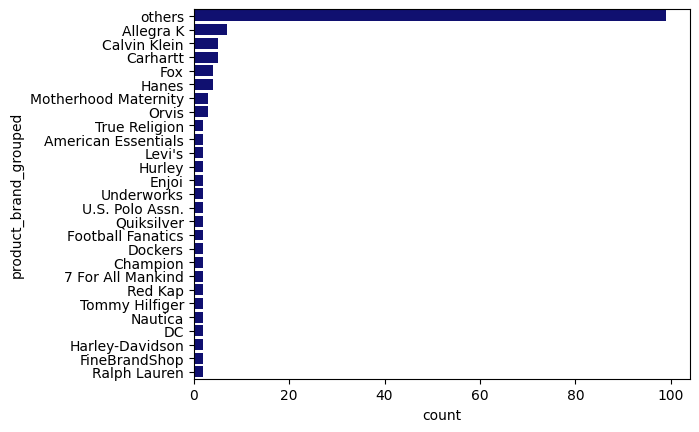

In [97]:
# product brand from clients with high repurchase probability
sns.barplot(
    y='product_brand_grouped', 
    x='count', 
    data=temp, 
    color='navy', orient='h'
)